# **Tissue EC19001-SC2100248, without batch correction**

In [ ]:
import sys
sys.path.append("../code")

In [ ]:
from code.data_prep.io import *
from code.data_prep.processing import *
from code.plotting.plot_settings import *
from code.plotting.palette import *

In [1]:
import scanpy as sc
from pathlib import Path
import numpy as np
import pandas as pd
import scrublet as scr

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sc.settings.verbosity=3

In [3]:
main_dir = "/projects/robson-lab/research/endometriosis/"
sample_id = "Endometriosis-revision-3"

sc.settings.figdir = f"{main_dir}figures/{sample_id}"
matplotlib.rcParams["figure.facecolor"]="white"

---

#### Doublet identification (Scrublet), QC & Filtering

done with scanpy-recipes with jupyterlab_1.3.1.sif

---

#### Compute Highly variable genes
<br>**Note**: this command will run data normalization before computing highly_variable_genes, 
<br> then it will remove mito-, hemo-, ribo- & cell_cycle genes from highly_variable_genes

In [8]:
combined = sc.read_h5ad(f"{main_dir}/data/h5ad/{sample_id}/{sample_id}-combined-20211210.h5ad")

In [9]:
bool_map = {"True": True, "False": False, "nan": False, True: True, False: False}
bool_func = lambda x: x.map(bool_map)

In [10]:
combined.var["mitochondrial"] = np.logical_or.reduce(
    combined.var.loc[:, combined.var.columns.str.startswith("mito")].apply(bool_func, axis=1).values, 
    axis=1
)
combined.var["hemoglobin"] = np.logical_or.reduce(
    combined.var.loc[:, combined.var.columns.str.startswith("hemo")].apply(bool_func, axis=1).values, 
    axis=1
)

combined.var["ribosomal"] = combined.var_names.str.startswith("RPL") |\
                            combined.var_names.str.startswith("RPS") |\
                            combined.var_names.str.startswith("MRPL") |\
                            combined.var_names.str.startswith("MRPS")

In [11]:
#cell_cycle & stress_response gene list (Kieran et al.)
sr_genes = pd.read_csv("../databases/coregene_stress-response.csv", header=0, index_col=6).index
cc_genes = pd.read_csv("../databases/cell_cycle.csv", header=0, index_col=1).index[:484]

In [12]:
combined.var["cell_cycle"]  = combined.var_names.isin(cc_genes)
combined.var["stress_response"] = combined.var_names.isin(sr_genes)

In [14]:
full = preprocess(combined, n_top_genes=2000)

normalizing counts per cell
    finished (0:00:01)
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [15]:
#check value after normalization
print (full.X.max())
print (full.layers["normed"].max())
print (full.layers["raw"].max())

8.913188
7428.3076
54610.0


---

#### Batch Corrections (SKIP!!)

---

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:19)


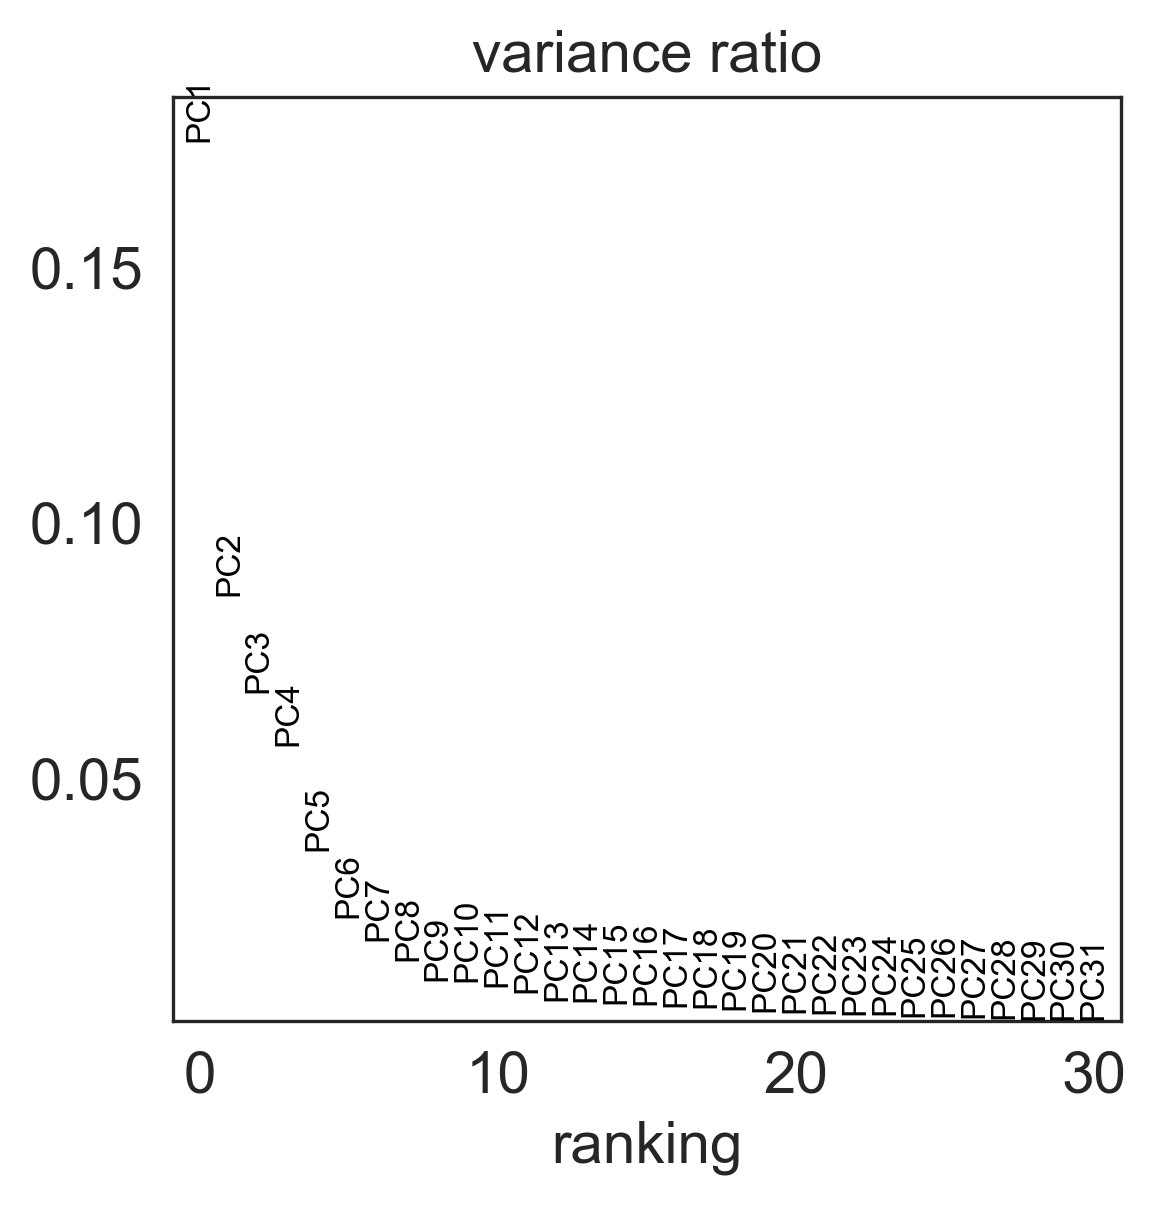

In [16]:
sc.pp.pca(full, svd_solver="arpack",use_highly_variable=True)
sc.pl.pca_variance_ratio(full,show=False)

In [17]:
sc.pp.neighbors(full, n_neighbors=15, n_pcs=10, metric="correlation")
sc.tl.umap(full, min_dist=0.1)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:25)
computing UMAP


/opt/conda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/opt/conda/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/opt/conda/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:57)


In [19]:
full

AnnData object with n_obs × n_vars = 111048 × 26636
    obs: 'sequencing_saturation', 'Patient_id', 'stage', 'scrublet_predicted_doublet', 'scrublet_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin', 'library', '10x_chemistry', 'sample_name', 'sampleid', 'sample_type'
    var: 'gene_ids', 'mitochondrial', 'hemoglobin', 'total_counts', 'n_cells_by_counts', 'ribosomal', 'cell_cycle', 'stress_response', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'output_dir', 'sampleid', 'raw_dtype', 'n_top_genes', 'log1p', 'pca', 'neighbors', 'umap', 'Patient_id_colors', 'sample_type_colors', 'stage_colors'
    obsm: 'X_pca', 'X_umap'
   

In [20]:
save_adata(full, suffix="combined-noHarmony")